# Monitors and Inputs

@[Chaoming Wang](https://github.com/chaoming0625)

BrainPy has a [systematic naming system](../tutorial_math/base.ipynb). Any model in BrainPy have a unique name. Thus, nodes, integrators, and variables can be easily accessed in a huge network. Based on this naming system, BrainPy provides a set of convenient monitoring and input supports. In this tutorial, we are going to talk about this. 

In [1]:
import brainpy as bp
import brainpy.math as bm

bp.math.set_platform('cpu')
bp.math.set_dt(0.02)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Monitors

In BrainPy, any instance of ``brainpy.Runner`` has a build-in monitor. Users can set up the monitor when initializing a runner. 

Here, we have the following `HH` neuron model,

In [3]:
class HH(bp.NeuGroup):
  def __init__(self, size, ENa=50., EK=-77., EL=-54.387, C=1.0, 
               gNa=120., gK=36., gL=0.03, V_th=20., name=None):
    super(HH, self).__init__(size=size, name=name)

    # parameters
    self.ENa = ENa
    self.EK = EK
    self.EL = EL
    self.C = C
    self.gNa = gNa
    self.gK = gK
    self.gL = gL
    self.V_th = V_th

    # variables
    self.V = bm.Variable(bm.ones(self.num) * -65.)
    self.m = bm.Variable(bm.ones(self.num) * 0.5)
    self.h = bm.Variable(bm.ones(self.num) * 0.6)
    self.n = bm.Variable(bm.ones(self.num) * 0.32)
    self.input = bm.Variable(bm.zeros(self.num))
    self.spike = bm.Variable(bm.zeros(self.num, dtype=bool))
    
    # functions
    self.integral = bp.odeint(self.derivative, method='rk4')

  def derivative(self, V, m, h, n, t, Iext):
    alpha = 0.1 * (V + 40) / (1 - bm.exp(-(V + 40) / 10))
    beta = 4.0 * bm.exp(-(V + 65) / 18)
    dmdt = alpha * (1 - m) - beta * m

    alpha = 0.07 * bm.exp(-(V + 65) / 20.)
    beta = 1 / (1 + bm.exp(-(V + 35) / 10))
    dhdt = alpha * (1 - h) - beta * h

    alpha = 0.01 * (V + 55) / (1 - bm.exp(-(V + 55) / 10))
    beta = 0.125 * bm.exp(-(V + 65) / 80)
    dndt = alpha * (1 - n) - beta * n

    I_Na = (self.gNa * m ** 3 * h) * (V - self.ENa)
    I_K = (self.gK * n ** 4) * (V - self.EK)
    I_leak = self.gL * (V - self.EL)
    dVdt = (- I_Na - I_K - I_leak + Iext) / self.C

    return dVdt, dmdt, dhdt, dndt

  def update(self, _t, _dt):
    V, m, h, n = self.integral(self.V, self.m, self.h, self.n, _t, self.input)
    self.spike.value = bm.logical_and(self.V < self.V_th, V >= self.V_th)
    self.V.value = V
    self.m.value = m
    self.h.value = h
    self.n.value = n
    self.input[:] = 0

In [4]:
model  = HH(1)

First method is to initialize a monitor is using a list/tuple of strings. 

In [15]:
# set up a monitor using a list of str
runner1 = bp.StructRunner(model, 
                          monitors=['V', 'spike'], 
                          inputs=('input', 10))

type(runner1.mon)

brainpy.simulation.monitor.Monitor

The initialized monitor is an instance of ``brainpy.Monitor``. Therefore, users can also directly use ``Monitor`` class to initialize a monitor. 

In [8]:
# set up a monitor using brainpy.Monitor
runner2 = bp.StructRunner(model, monitors=bp.Monitor(variables=['V', 'spike']))

Once we call the ``.run()`` function in the runner, the monitor will automatically record the variable evolutions in the corresponding models. Afterwards, users can access these variable trajectories by using ``.mon.[variable_name]``. The default history times ``.mon.ts`` will also be generated after the model finishes its running. Let's see an example. 

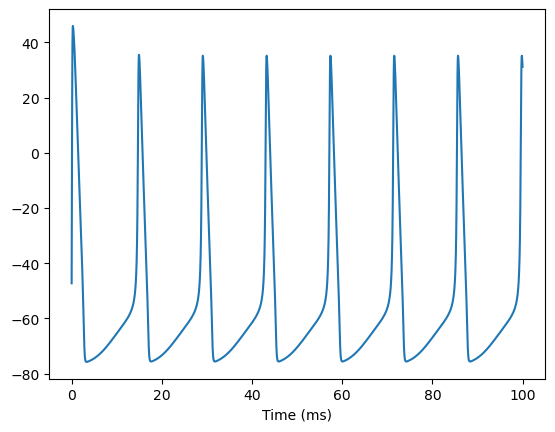

In [16]:
runner1.run(100.)

bp.visualize.line_plot(runner1.mon.ts, runner1.mon.V, show=True)

The monitor in ``runner1`` has recorded the evolution of `V`. Therefore, it can be accessed by ``runner1.mon.V`` or equivalently ``runner1.mon['V']``. Similarly, the recorded trajectory of variable `spike` can also be obtained through ``runner1.mon.spike``. 

In [17]:
runner1.mon.spike

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

### The mechanism of ``monitors``

We want to record ``HH.V`` and ``HH.spike``, why we define ``monitors=['V', 'spike']`` during ``HH`` initialization is successful? How does ``brainpy.Monitor`` recognize what variables I want to trace?

Actually, BrainPy first tries to find the interested variables in the simulation target by [the relative path](../tutorial_math/base.ipynb). If not found, BrainPy checks whether the variable can be accessed by [the absolute path](../tutorial_math/base.ipynb) by the simluation target. Not found again? An error will be raised. 

In [20]:
net = bp.Network(HH(size=10, name='X'), 
                 HH(size=20, name='Y'), 
                 HH(size=30))

# it's ok
bp.StructRunner(net, monitors=['X.V', 'Y.spike']).build_monitors()  

<function monitor_step(_t, _dt)>

In the above ``net``, there are ``HH`` instances named as "X" and "Y". Therefore, trying to monitor "X.V" and "Y.spike" is successful. 

However, in the following example, node named with "Z" is not accessible in the generated ``net``. Therefore the monitoring setup failed. 

In [5]:
z = HH(size=30, name='Z')
net = bp.Network(HH(size=10), HH(size=20))

# node "Z" can not be accessed in the simulation target 'net'
try:
    bp.StructRunner(net, monitors=['Z.V']).build_monitors()  
except Exception as e:
    print(type(e).__name__, ":", e)

RunningError : Cannot find target Z.V in monitor of <brainpy.simulation.brainobjects.network.Network object at 0x000002A3D28D19A0>, please check.


```{note}
BrainPy only supports to monitor [Variable](../tutorial_math/variables.ipynb). This is because monitoring [Variable](../tutorial_math/variables.ipynb)'s trajectory is meaningful. They are dynamically changed, and others not marked as Variable will be compiled as constants. 
```

In [6]:
try:
    bp.StructRunner(HH(size=1), monitors=['gNa']).build_monitors() 
except Exception as e:
    print(type(e).__name__, ":", e)

RunningError : "gNa" in <__main__.HH object at 0x000002A3D239ADF0> is not a dynamically changed Variable, its value will not change, we think there is no need to monitor its trajectory.


```{note}
The monitors in BrainPy only record the flattened tensor values. This means if your target variable is a matrix with the shape of ``(N, M)``, the resulting trajectory value in the monitor after running ``T`` times will be a tensor with the shape of ``(T, N x M)``.
```

In [8]:
class MatrixVarModel(bp.DynamicalSystem):
    def __init__(self, **kwargs):
        super(MatrixVarModel, self).__init__(**kwargs)
        
        self.a = bm.Variable(bm.zeros((4, 4)))
    
    def update(self, _t, _dt):
        self.a += 0.01
        
        
model = MatrixVarModel()
duration = 10
runner = bp.StructRunner(model, monitors=['a'])
runner.run(duration)

print(f'The expected shape of "model.mon.a" is: {(int(duration/bm.get_dt()), model.a.size)}')
print(f'The actual shape of "model.mon.a" is: {runner.mon.a.shape}')

The expected shape of "model.mon.a" is: (500, 16)
The actual shape of "model.mon.a" is: (500, 16)


### Monitor variables at the selected index

Sometimes, we do not always take care of the all the content in a variable. We may be only interested in the values at the selected index. Moreover, for a huge network with a long time simulation, monitors will be a big part to consume RAM. So, only monitoring variables at the selected index will be a good solution. Fortunately, BrainPy supports to monitor a part of elements in a Variable with the format of tuple/dict like this:

In [9]:
runner = bp.StructRunner(
    HH(10),
    monitors=['V',  # monitor all values of Variable 'V' 
              ('spike', [1, 2, 3])], # monitor values of Variable at index of [1, 2, 3]
    inputs=('input', 10.)
)
runner.run(100.)

print(f'The monitor shape of "V" is (run length, variable size) = {runner.mon.V.shape}')
print(f'The monitor shape of "spike" is (run length, index size) = {runner.mon.spike.shape}')

The monitor shape of "V" is (run length, variable size) = (5000, 10)
The monitor shape of "spike" is (run length, index size) = (5000, 3)


Or, we can use a dictionary to specify the interested index of the variable:

In [11]:
runner = bp.StructRunner(
    HH(10),
    monitors={'V': None,  # 'None' means all values will be monitored
              'spike': [1, 2, 3]},  # specify the interested index 
    inputs=('input', 10.),
)
runner.run(100.)

print(f'The monitor shape of "V" is (run length, variable size) = {runner.mon.V.shape}')
print(f'The monitor shape of "spike" is (run length, index size) = {runner.mon.spike.shape}')

The monitor shape of "V" is (run length, variable size) = (5000, 10)
The monitor shape of "spike" is (run length, index size) = (5000, 3)


Also, we can directly instantiate a `brainpy.Monitor` class:

In [12]:
runner = bp.StructRunner(
    HH(10),
    monitors=bp.Monitor(variables=['V', ('spike', [1, 2, 3])]), 
    inputs=('input', 10.),
)
runner.run(100.)

print(f'The monitor shape of "V" is (run length, variable size) = {runner.mon.V.shape}')
print(f'The monitor shape of "spike" is (run length, index size) = {runner.mon.spike.shape}')

The monitor shape of "V" is (run length, variable size) = (5000, 10)
The monitor shape of "spike" is (run length, index size) = (5000, 3)


In [14]:
runner = bp.StructRunner(
    HH(10),
    monitors=bp.Monitor(variables={'V': None, 'spike': [1, 2, 3]}),
    inputs=('input', 10.),
)
runner.run(100.)

print(f'The monitor shape of "V" is (run length, variable size) = {runner.mon.V.shape}')
print(f'The monitor shape of "spike" is (run length, index size) = {runner.mon.spike.shape}')

The monitor shape of "V" is (run length, variable size) = (5000, 10)
The monitor shape of "spike" is (run length, index size) = (5000, 3)



```{note}
When users want to record a small part of a variable whose dimension > 1,  due to ``brainpy.Monitor`` records a flattened tensor variable, they must provide the index positions at the flattened tensor.  
```

### Monitor variables with a customized period

In a long simulation with a small time step `dt` , what we take care about is the trend of the variable evolution, not the exact values at each time point (especially when `dt` is very small). For this scenario, we can initialize the monitors with the `intervals` item specification. 

However, ``intervals`` setting is only supported in the ``brainpy.ReportRunner``. 

In [15]:
runner = bp.ReportRunner(
    HH(10),
    monitors=bp.Monitor(variables={'V': None, 'spike': [1, 2, 3]},
                        intervals={'V': None, 'spike': 1.}),  # in 1 ms, we record 'spike' only once
    inputs=('input', 10.),
)

In this example, we monitor "spike" variables at the index of [1, 2, 3] for each `1 ms`. 

In [16]:
runner.run(100.)

print(f'The monitor shape of "V" = {runner.mon.V.shape}')
print(f'The monitor shape of "spike" = {runner.mon.spike.shape}')

Compilation used 0.2560 s.
Start running ...
Run 10.0% used 3.361 s.
Run 20.0% used 6.620 s.
Run 30.0% used 9.808 s.
Run 40.0% used 12.977 s.
Run 50.0% used 16.157 s.
Run 60.0% used 19.337 s.
Run 70.0% used 22.539 s.
Run 80.0% used 25.746 s.
Run 90.0% used 28.946 s.
Run 100.0% used 32.139 s.
Simulation is done in 32.139 s.

The monitor shape of "V" = (5000, 10)
The monitor shape of "spike" = (99, 3)


It's worthy to note that for the monitor variable `[variable_name]` with a non-none ``intervals`` specification, a corresponding time item `[variable_name].t` will be generated in the monitor. This is because it's time trajectory will be different from the default time trajectory. 

In [17]:
print('The shape of ["spike"]: ', runner.mon['spike'].shape)
print('The shape of ["spike.t"]: ', runner.mon['spike.t'].shape)

print('group7.mon["spike.t"]: ', runner.mon["spike.t"])

The shape of ["spike"]:  (99, 3)
The shape of ["spike.t"]:  (99,)
group7.mon["spike.t"]:  [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53. 54.
 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71. 72.
 73. 74. 75. 76. 77. 78. 79. 80. 81. 82. 83. 84. 85. 86. 87. 88. 89. 90.
 91. 92. 93. 94. 95. 96. 97. 98. 99.]


## Inputs

BrainPy also provides `inputs` operation for each instance of ``brainpy.Runner``.

The aim of ``inputs`` is to mimic the input operations in experiments like Transcranial Magnetic Stimulation (TMS) and patch clamp recording. ``inputs`` should have the format like ``(target, value, [type, operation])``, where 

- ``target`` is the target variable to inject the input. 
- ``value`` is the input value. It can be a scalar, a tensor, or a iterable object/function. 
- ``type`` is the type of the input value. It support two types of input: ``fix`` and ``iter``. 
- ``operation`` is the input operation on the target variable. It should be set as one of `{ + , - , * , / , = }`, and if users do not provide this item explicitly, it will be set to '+' by default, which means that the target variable will be updated as ``val = val + input``. 

You can also give multiple inputs for different target variables, like:

```python

inputs=[(target1, value1, [type1, op1]),  
        (target2, value2, [type2, op2]),
              ... ]
```

### The mechanism of ``inputs``

The mechanism of ``inputs`` is the same with ``monitors``. BrainPy finds out the target variables to do the input operation through [the absolute or relative path](../tutorial_math/base.ipynb). 

In [23]:
class Model(bp.DynamicalSystem):
    def __init__(self, num_sizes, **kwargs):
        super(Model, self).__init__(**kwargs)
        
        self.l1 = HH(num_sizes[0], name='L')
        self.l2 = HH(num_sizes[1])
        self.l3 = HH(num_sizes[2])
        
    def update(self, _t, _dt):
        self.l1.update(_t, _dt)
        self.l2.update(_t, _dt)
        self.l3.update(_t, _dt)
        
model = Model([10, 20, 30])

In [24]:
runner = bp.StructRunner(
    model,
    inputs=[('L.V', 2.0),  # access with the absolute path
            ('l2.V', 1),]  # access with the relative path
)
runner.run(100.)

2.9371795654296875

``inputs`` supports two types of data: ``fix`` and ``iter``. The first one means that the data is static; the second one denotes the data can be iterable, no matter the input value is a tensor or a function. Note, `'iter'` type must be explicitly stated. 

In [25]:
# a tensor

runner = bp.StructRunner(model, inputs=('L.V', bm.ones(1000) * 2., 'iter'))
runner.run(100.)

2.8953235149383545

In [27]:
# a function

def current():
    while True: yield 2.

runner = bp.StructRunner(model, inputs=('L.V', current(), 'iter'))
runner.run(100.)

2.9955742359161377

## Input construction functions 

Inputs are common in a computational experiment. Also, we need various kind of inputs. In BrainPy, we provide several convenient input functions to help users construct input currents. 

### ``brainpy.inputs.section_input()``

[brainpy.inputs.section_input()](../apis/simulation/generated/brainpy.simulation.inputs.section_input.rst) is an updated function of previous `brainpy.inputs.constant_input()` (see below). 

Sometimes, we need input currents with different values in different periods. For example, if you want to get an input in which 0-100 ms is zero, 100-400 ms is value 1., and 400-500 ms is zero, then, you can define:

In [23]:
current, duration = bp.inputs.section_input(values=[0, 1., 0.],
                                            durations=[100, 300, 100],
                                            return_length=True)

In [24]:
def show(current, duration, title):
    ts = np.arange(0, duration, 0.1)
    plt.plot(ts, current)
    plt.title(title)
    plt.xlabel('Time [ms]')
    plt.ylabel('Current Value')
    plt.show()

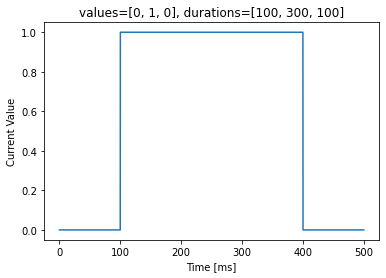

In [25]:
show(current, duration, 'values=[0, 1, 0], durations=[100, 300, 100]')

### ``brainpy.inputs.constant_input()``

[brainpy.inputs.constant_input()](../apis/simulation/generated/brainpy.simulation.inputs.constant_input.rst) function helps you to format constant currents in several periods.

For the input created above, we can define it again with `constant_input()` by:

In [26]:
current, duration = bp.inputs.constant_input([(0, 100), (1, 300), (0, 100)])

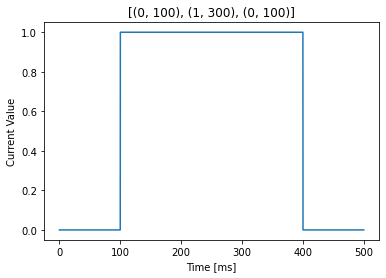

In [27]:
show(current, duration, '[(0, 100), (1, 300), (0, 100)]')

Another example is this:

In [28]:
current, duration = bp.inputs.constant_input([(-1, 10), (1, 3), (3, 30), (-0.5, 10)], dt=0.1)

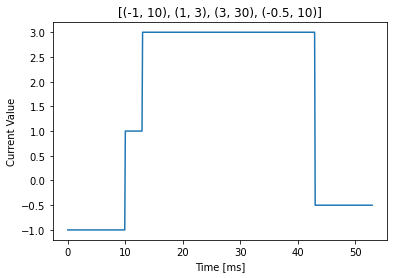

In [29]:
show(current, duration, '[(-1, 10), (1, 3), (3, 30), (-0.5, 10)]')

### ``brainpy.inputs.spike_input()``

[brainpy.inputs.spike_input()](../apis/simulation/generated/brainpy.simulation.inputs.spike_input.rst) helps you to construct an input like a series of short-time spikes. It receives the following settings:

- `sp_times` :  The spike time-points. Must be an iterable object. For example, list, tuple, or arrays.
- `sp_lens` : The length of each point-current, mimicking the spike durations. It can be a scalar float to specify the unified duration. Or, it can be list/tuple/array of time lengths with the length same with `sp_times`. 
- `sp_sizes` : The current sizes. It can be a scalar value. Or, it can be a list/tuple/array of spike current sizes with the length same with `sp_times`.
- `duration` : The total current duration.
- `dt` : The time step precision. The default is None (will be initialized as the default `dt` step). 

For example, if you want to generate a spike train at 10 ms, 20 ms, 30 ms, 200 ms, 300 ms,
    and each spike lasts 1 ms and the spike current is 0.5, then you can use the
    following funtions:

In [30]:
current = bp.inputs.spike_input(
    sp_times=[10, 20, 30, 200, 300],
    sp_lens=1.,  # can be a list to specify the spike length at each point
    sp_sizes=0.5,  # can be a list to specify the spike current size at each point
    duration=400.)

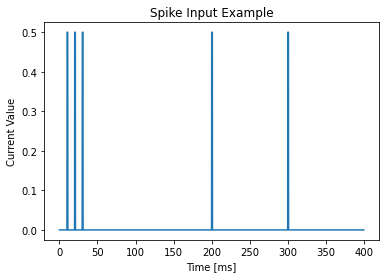

In [31]:
show(current, 400, 'Spike Input Example')

### ``brainpy.inputs.ramp_input()``

[brainpy.inputs.ramp_input()](../apis/simulation/generated/brainpy.simulation.inputs.ramp_input.rst) mimics a ramp or a step current to the input of the circuit. It receives the following settings:

- `c_start` : The minimum (or maximum) current size.
- `c_end` : The maximum (or minimum) current size.
- `duration` : The total duration.
- `t_start` : The ramped current start time-point.
- `t_end` : The ramped current end time-point. Default is the None.
- `dt` : The current precision.

We illustrate the usage of `brainpy.inputs.ramp_input()` by two examples.

In the first example, we increase the current size from 0. to 1. between the start time (0 ms) and the end time (1000 ms). 

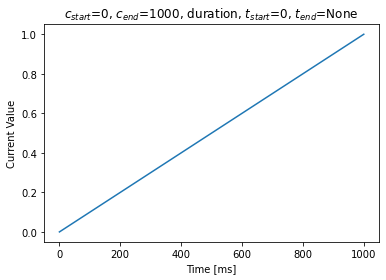

In [32]:
duration = 1000
current = bp.inputs.ramp_input(0, 1, duration)

show(current, duration, r'$c_{start}$=0, $c_{end}$=%d, duration, '
                        r'$t_{start}$=0, $t_{end}$=None' % (duration))

In the second example, we increase the current size from 0. to 1. from the 200 ms to 800 ms.

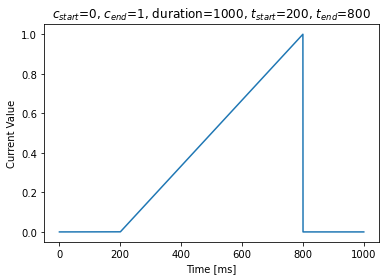

In [33]:
duration, t_start, t_end = 1000, 200, 800
current = bp.inputs.ramp_input(0, 1, duration, t_start, t_end)

show(current, duration, r'$c_{start}$=0, $c_{end}$=1, duration=%d, '
                        r'$t_{start}$=%d, $t_{end}$=%d' % (duration, t_start, t_end))

### General property of input functions

There are several general properties for input construction functions. 

**Property 1**: All input functions can automatically broadcast the current shapes, if they are heterogenous among different periods. For example, during period 1 we give an input with a scalar value, during period 2 we give an input with a vector shape, and during period 3 we give a matrix input value. Input functions will broadcast them to the maximum shape. For example, 

In [34]:
current = bp.inputs.section_input(values=[0, bm.ones(10), bm.random.random((3, 10))],
                                  durations=[100, 300, 100])

current.shape

(5000, 3, 10)

**Property 2**: Every input function receives a ``dt`` specification. If ``dt`` is not provided, input functions will use the default ``dt`` in the whole BrainPy system. 

In [35]:
bp.inputs.section_input(values=[0, 1, 2], durations=[10, 20, 30], dt=0.02).shape

(3000,)

In [36]:
bp.inputs.section_input(values=[0, 1, 2], durations=[10, 20, 30], dt=0.2).shape

(300,)

In [37]:
# the default 'dt' in 0.1

bp.inputs.section_input(values=[0, 1, 2], durations=[10, 20, 30]).shape

(600,)